# Inflation and contributions

In [1]:
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import re

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

*Formula to compute contributions of each sub-item to the inflation index*:

$CTR_{m, k}^{a} = \frac{1}{I_{m, a-1}} [w_a^{k} \frac{I_{dec, a-1}}{I_{dec, a-1}^{k}} (I_{m, a-1}^{k} - I_{dec, a-1}^{k}) + w_{a-1}^{k} \frac{I_{dec, a-2}}{I_{dec, a-2}^{k}} (I_{dec, a-1}^{k} - I_{m, a-1}^{k})]$


* $k$ is the index of the sub-item, if it is not used the variable value corresponds to the agregated index
* $I$ is the index in nominal values
* $CTR_{m, a}^{k}$ contribution of sub-item k to the inflation index on year a and month m
* $w_a^{k}$ is the weight of the sub-item k in the agregated index for year a
* $m=dec$, december value is used

In [3]:
# from pynsee import init_conn
# init_conn(insee_key='key', insee_secret='secret')

In [4]:
# download a list of inflation dataset series identifiers
series = get_series_list('IPC-2015')

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/48719b3a81bc306982ce59585ceb295f.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/d8d557aac16cb9a7c1a31036b2a0c591.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
INSEE API credentials have not been found: please try to reuse pynsee.init_conn to save them locally.
Otherwise, you can still use environment variables as follow:

import os
os.environ['sirene_key'] = 'my_sirene_key'
https://api.insee.fr/series/BDM/V1/datastructure/FR1/IPC-2015
Data saved:
/home/onyxia/.cache/pynsee/pynsee/b2515683c224ab87c8927b2bdc3e6f67.parquet
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/9bd33a4f18da8c55c6a8a738b9cf3cea.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cac

In [5]:
# total inflation series identifier
IdInflation = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "00") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO == "SO")]

# price indexes including in inflation total index
IdIndices = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009", "4007"]))]

# weights of price indexes including in inflation total index
IdPond = series.loc[(series.FREQ == "A") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009", "4007"]))]


In [6]:
# collect data
inflation = get_series(IdInflation.IDBANK)
indices = get_series(IdIndices.IDBANK)
pond = get_series(IdPond.IDBANK)

https://api.insee.fr/series/BDM/V1/data/SERIES_BDM/001759970
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/d8d557aac16cb9a7c1a31036b2a0c591.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/48719b3a81bc306982ce59585ceb295f.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data


Metadata download:   0%|          | 0/1 [00:00<?, ?it/s]

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/be75364011bd8af0c1b63ccda41105a6.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data


Metadata download: 100%|██████████| 1/1 [00:00<00:00, 32.57it/s]

Data saved:
/home/onyxia/.cache/pynsee/pynsee/07078a87381c71e51c92c602d6694841.parquet
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/f3805eaca1bdfd618a8ac8d53d410b60.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/1f5fd9f024c0440edd7f284422e178b1.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/4a0d6e080c92889d6e1412250ab53c51.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/4a452baed0d45d6ea1a029f6e96a856b.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/d15c39f20fa0bad72b8d48ff0f5ef778.parquet
Creation date: 2025-05-27, to

Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/d8d557aac16cb9a7c1a31036b2a0c591.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/07078a87381c71e51c92c602d6694841.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/f3805eaca1bdfd618a8ac8d53d410b60.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/1f5fd9f024c0440edd7f284422e178b1.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/4a0d6e080c92889d6e1412250ab53c51.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used

In [7]:
# compute ponderation and annual growth rate
pond['pond'] = pond.OBS_VALUE / pond.groupby(['DATE']).OBS_VALUE.transform('sum')
indices['growth'] = (indices.OBS_VALUE/ indices.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100
inflation['growth'] = (inflation.OBS_VALUE/ inflation.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100

In [8]:
inflation['month'] = inflation['DATE'].apply(lambda x: x.month)
indices['month'] = indices['DATE'].apply(lambda x: x.month)

inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
indices['year'] = indices['DATE'].apply(lambda x: x.year)
pond['year'] = pond['DATE'].apply(lambda x: x.year)

inflation = inflation.rename(columns = {"OBS_VALUE" : "inflation"})
indices = indices.rename(columns = {"OBS_VALUE" : "indices"})

inflationDec = inflation[inflation['month'] == 12]
indicesDec = indices[indices['month'] == 12]

indicesDec = indicesDec.rename(columns = {"indices" : "indicesDec"})
indicesDec = indicesDec[["year", "COICOP2016", "indicesDec", "PRIX_CONSO"]]

inflationDec = inflationDec.rename(columns = {"inflation" : "inflationDec"})
inflationDec = inflationDec[["year", "COICOP2016", "inflationDec", "PRIX_CONSO"]]

pond = pond[["year", "COICOP2016", "pond", "PRIX_CONSO"]]

In [9]:
# merge all datasets
data = indices.merge(indicesDec, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(pond, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(inflation[['DATE', 'inflation']], on = ["DATE"], how = 'left')
data = data.merge(inflationDec[['year', 'inflationDec']], on = ["year"], how = 'left')

In [10]:
# compute contributions by coicop
df = data.groupby(['month', 'COICOP2016', 'PRIX_CONSO'], as_index=False)

data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] * 
                      (x['indices'] / x['indicesDec'].shift(1) - 1)).reset_index(level=0, drop=True)

data['contrib2'] = df.apply(lambda x: x['pond'].shift(1) * x['inflationDec'].shift(2) / x['indicesDec'].shift(2) *
                      (x['indicesDec'].shift(1) - x['indices'].shift(1))).reset_index(level=0, drop=True)

data['contrib'] =  df.apply(lambda x: 100 * (x['contrib1'] + x['contrib2']) /
                            x['inflation'].shift(1)).reset_index(level=0, drop=True)        

# reshape dataframe for plotting purposes
data2 = data[data['year'] >= 2008].sort_values(by="DATE").reset_index()
data2 = data2[['DATE', 'PRIX_CONSO_label_en', 'contrib']]
data2 = data2.pivot(index="DATE", columns="PRIX_CONSO_label_en", values="contrib")

/tmp/ipykernel_1983/648722610.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] *
/tmp/ipykernel_1983/648722610.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['contrib2'] = df.apply(lambda x: x['pond'].shift(1) * x['inflationDec'].shift(2) / x['indicesDec'].shift(2) *
/tmp/ipykernel_1983/648722610.py:10: DeprecationWarn

In [17]:
# dfChecks = data.groupby(['DATE'], as_index=False)['contrib'].agg('sum')
# dfChecks = dfChecks.merge(inflation[['DATE', 'growth']], on='DATE', how='left')

In [18]:
# check that the sum of contribution is equal to annual growth rate of inflation
dfChecks = data.groupby(['DATE'], as_index=False)['contrib'].agg('sum')
dfChecks['DATE'] = pd.to_datetime(dfChecks['DATE'])
inflation_merge = inflation[['DATE', 'growth']]
inflation_merge['DATE'] = pd.to_datetime(inflation_merge['DATE'])
dfChecks = dfChecks.merge(inflation_merge, on='DATE', how='left')
dfChecks = dfChecks[dfChecks['DATE'] >= "2008-01-01"].reset_index()

/tmp/ipykernel_1983/2763205618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_merge['DATE'] = pd.to_datetime(inflation_merge['DATE'])


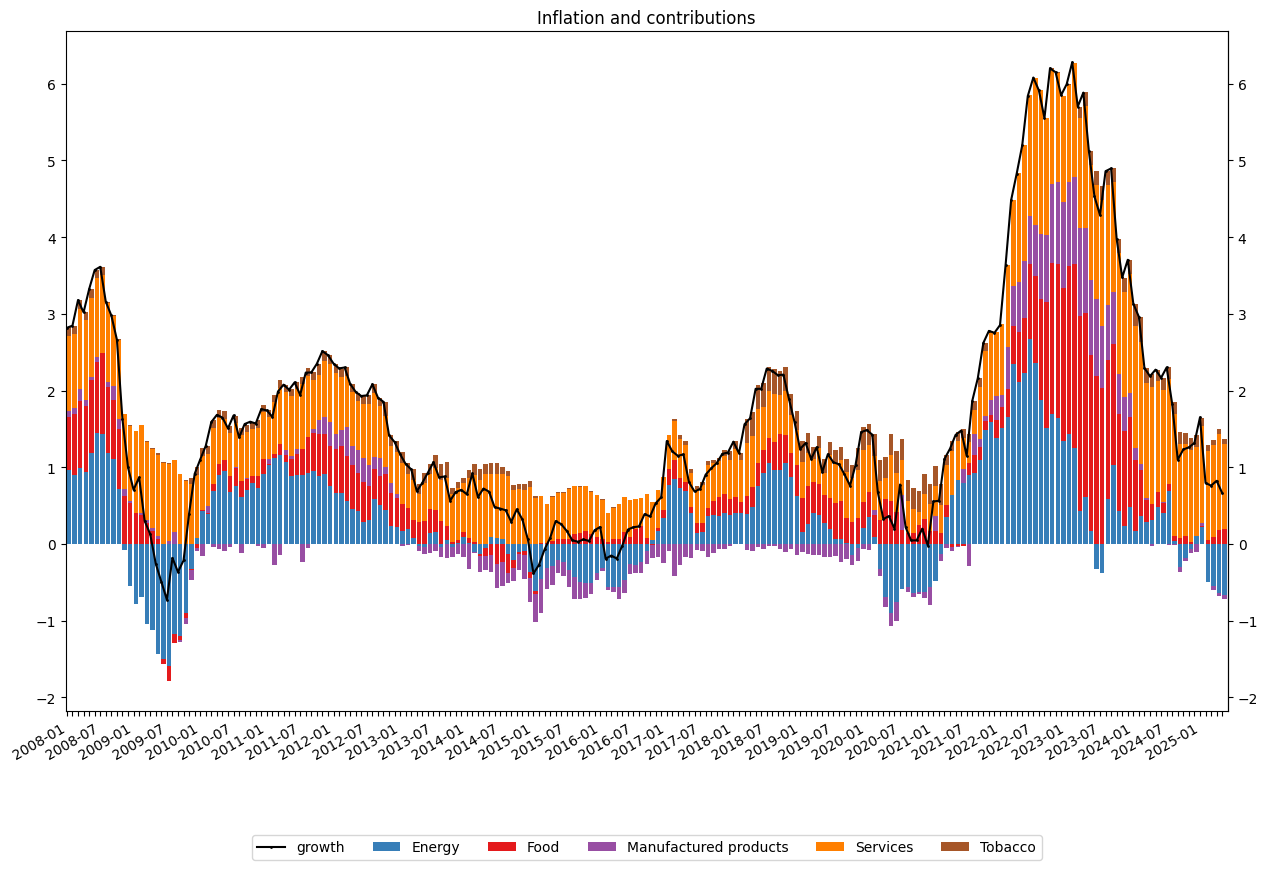

In [20]:
# make color palette
#colors = sns.color_palette("Set1") + sns.color_palette("Set2")

colors = [sns.color_palette("Set1")[1]] + \
        [c for i, c in enumerate(sns.color_palette("Set1")) if i not in [1, 2, 5]]

#
# draw plot
#

ax = data2.plot(kind='bar', stacked=True, align='edge', width=0.8,
                color=colors, figsize=(15,10))
#dfChecks.plot(ax=ax, y = "contrib", marker="x", color="b", markersize=1)
dfChecks.plot(ax=ax, y = "growth", marker="o", color="black", markersize=1)

#add title
plt.title("Inflation and contributions")

# customize x-axis tickers
time_period = [str(x)[:7] for x in data2.index]
ticklabels = ['']*len(data2.index)
ticklabels[::6] = [item for item in time_period[::6]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
#remove legend
ax.get_legend().remove()
#remove x-axistitle
ax.xaxis.label.set_visible(False)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='center', ncol=len(data2.columns)+1)
ax.secondary_yaxis('right')
plt.show()

In [ ]:
#
# Inflation, contributions with an energy focus
#

In [22]:
# total inflation series identifier
IdInflation = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "00") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO == "SO")]

# price indexes including in inflation total index
IdIndices = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009"]))]

IdIndicesEnergy = series.loc[(series.FREQ == "M") &
            (series.COICOP2016.isin(["0452", "0451", "0453", "0454", "07221", "07222", "07223"])) &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["SO"]))]

IdIndices = pd.concat([IdIndices, IdIndicesEnergy])

# weights of price indexes including in inflation total index
IdPond = series.loc[(series.FREQ == "A") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009"]))]

IdPondEnergy = series.loc[(series.FREQ == "A") &
            (series.COICOP2016.isin(["0452", "0451", "0453", "0454", "07221", "07222", "07223"])) &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["SO"]))]


IdPond = pd.concat([IdPond, IdPondEnergy])

# collect data
inflation = get_series(IdInflation.IDBANK)
indices = get_series(IdIndices.IDBANK)
pond = get_series(IdPond.IDBANK)

# compute ponderation and annual growth rate
pond['pond'] = pond.OBS_VALUE / pond.groupby(['DATE']).OBS_VALUE.transform('sum')
indices['growth'] = (indices.OBS_VALUE/ indices.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100
inflation['growth'] = (inflation.OBS_VALUE/ inflation.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100

inflation['month'] = inflation['DATE'].apply(lambda x: x.month)
indices['month'] = indices['DATE'].apply(lambda x: x.month)

inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
indices['year'] = indices['DATE'].apply(lambda x: x.year)
pond['year'] = pond['DATE'].apply(lambda x: x.year)

inflation = inflation.rename(columns = {"OBS_VALUE" : "inflation"})
indices = indices.rename(columns = {"OBS_VALUE" : "indices"})

inflationDec = inflation[inflation['month'] == 12]
indicesDec = indices[indices['month'] == 12]

indicesDec = indicesDec.rename(columns = {"indices" : "indicesDec"})
indicesDec = indicesDec[["year", "COICOP2016", "indicesDec", "PRIX_CONSO"]]

inflationDec = inflationDec.rename(columns = {"inflation" : "inflationDec"})
inflationDec = inflationDec[["year", "COICOP2016", "inflationDec", "PRIX_CONSO"]]

pond = pond[["year", "COICOP2016", "pond", "PRIX_CONSO"]]

inflation_merge = inflation[['DATE', 'inflation']]
inflation_merge['DATE'] = pd.to_datetime(inflation_merge['DATE'])

# merge all datasets
data = indices.merge(indicesDec, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(pond, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.merge(inflation_merge[['DATE', 'inflation']], on = ["DATE"], how = 'left')
data = data.merge(inflationDec[['year', 'inflationDec']], on = ["year"], how = 'left')

# compute contributions by coicop
df = data.groupby(['month', 'COICOP2016', 'PRIX_CONSO'], as_index=False)

data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] * 
                      (x['indices'] / x['indicesDec'].shift(1) - 1)).reset_index(level=0, drop=True)

data['contrib2'] = df.apply(lambda x: x['pond'].shift(1) * x['inflationDec'].shift(2) / x['indicesDec'].shift(2) *
                      (x['indicesDec'].shift(1) - x['indices'].shift(1))).reset_index(level=0, drop=True)

data['contrib'] =  df.apply(lambda x: 100 * (x['contrib1'] + x['contrib2']) /
                            x['inflation'].shift(1)).reset_index(level=0, drop=True)        


Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/75e55239e1aed0fea3ed0ba8ebc926f0.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/285dea1af843596db0f0a1d410c3f8c9.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data
Previously saved data has been used:
/home/onyxia/.cache/pynsee/pynsee/95c41f8095de2f15bb36273d634f7fd4.parquet
Creation date: 2025-05-27, today
Set update=True to get the most up-to-date data


/tmp/ipykernel_1983/3402247406.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inflation_merge['DATE'] = pd.to_datetime(inflation_merge['DATE'])
/tmp/ipykernel_1983/3402247406.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] *
/tmp/ipykernel_1983/3402247406.py:91: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and 

In [23]:
def clean_string(x):
    return re.sub("\d|\.|\s|-", "", x)
    
data['COICOP2016_label_en'] = data['COICOP2016_label_en'].apply(lambda x: clean_string(x))

data['COICOP2016_label_en'] = np.where((data['COICOP2016'].isin(["0453", "0454", "07223"])),
                                       "other",      
                                       data['COICOP2016_label_en'])

data['PRIX_CONSO_label_en'] = np.where((data['PRIX_CONSO'] == "SO"),
                                       "Energy - " + data['COICOP2016_label_en'],      
                                       data['PRIX_CONSO_label_en'])


data2 = data.groupby(['DATE', "year",'PRIX_CONSO_label_en'], as_index=False).contrib.agg('sum')

# reshape dataframe for plotting purposes
data2 = data2[data2['year'] >= 2008].sort_values(by="DATE").reset_index()
data2 = data2[['DATE', 'PRIX_CONSO_label_en', 'contrib']]
data2 = data2.pivot(index="DATE", columns="PRIX_CONSO_label_en", values="contrib")
data2 = data2.dropna()

# check that the sum of contribution is equal to annual growth rate of inflation
dfChecks = data.groupby(['DATE'], as_index=False)['contrib'].agg('sum')
dfChecks = dfChecks.merge(inflation[['DATE', 'growth']], on='DATE', how='left')
dfChecks = dfChecks[dfChecks['DATE'] >= "2008-01-01"].reset_index()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1983/3471955260.py:2: SyntaxWarning: invalid escape sequence '\d'
  return re.sub("\d|\.|\s|-", "", x)


In [24]:
# make color palette
colors = [c for i, c in enumerate(sns.color_palette("Blues")) if i in range(5)][::-1] + \
        [c for i, c in enumerate(sns.color_palette("Set1")) if i not in [1, 2, 5]]
       

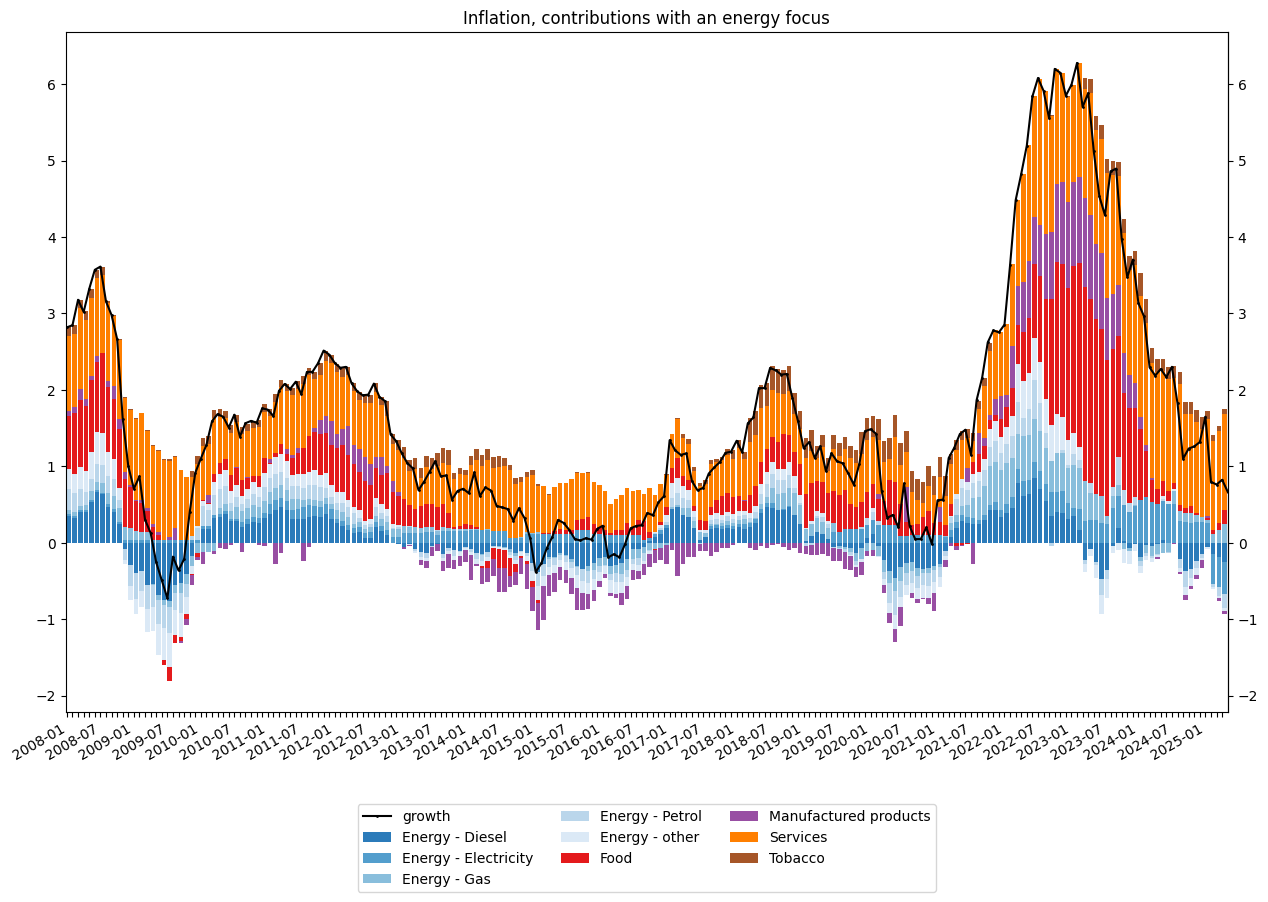

In [25]:

#
# draw plot
#

ax = data2.plot(kind='bar', stacked=True, align='edge', width=0.8,
                color=colors, figsize=(15,10))
#dfChecks.plot(ax=ax, y = "contrib", marker="x", color="b", markersize=1)
dfChecks.plot(ax=ax, y = "growth", marker="o", color="black", markersize=1)

#add title
plt.title("Inflation, contributions with an energy focus")

# customize x-axis tickers
time_period = [str(x)[:7] for x in data2.index]
ticklabels = ['']*len(data2.index)
ticklabels[::6] = [item for item in time_period[::6]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
#remove legend
ax.get_legend().remove()
#remove x-axistitle
ax.xaxis.label.set_visible(False)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='center', ncol=3)
ax.secondary_yaxis('right')
plt.show()